In [1]:
# Q-1(a,b):
import numpy as np
import pandas as pd

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def _entropy(self, y):
        """Calculate entropy of a set of labels."""
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def _information_gain(self, y, y_left, y_right):
        """Calculate information gain after a split."""
        p = len(y_left) / len(y)
        return self._entropy(y) - p * self._entropy(y_left) - (1 - p) * self._entropy(y_right)

    def _best_split(self, X, y):
        """Find the best feature and threshold to split on."""
        best_gain = -1
        best_feature = None
        best_threshold = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] < threshold
                right_indices = X[:, feature] >= threshold
                if sum(left_indices) == 0 or sum(right_indices) == 0:
                    continue
                gain = self._information_gain(y, y[left_indices], y[right_indices])
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth=0):
        """Recursively build the decision tree."""
        num_samples, num_features = X.shape
        num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]
        predicted_class = np.argmax(num_samples_per_class)

        # Stopping conditions
        if (depth >= self.max_depth or
            num_samples < self.min_samples_leaf or
            len(np.unique(y)) == 1):
            return predicted_class

        # Find the best split
        feature, threshold = self._best_split(X, y)
        if feature is None:
            return predicted_class

        # Split the data
        left_indices = X[:, feature] < threshold
        right_indices = X[:, feature] >= threshold

        # Recursively build left and right subtrees
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {
            'feature': feature,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree
        }

    def train(self, xFeat, y):
        """Train the decision tree."""
        self.tree = self._build_tree(xFeat, y)

    def _predict_sample(self, x, tree):
        """Predict the class for a single sample."""
        if not isinstance(tree, dict):
            return tree  # Leaf node, return the predicted class

        feature = tree['feature']
        threshold = tree['threshold']

        if x[feature] < threshold:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

    def predict(self, xFeat):
        """Predict the class for each sample in xFeat."""
        return np.array([self._predict_sample(x, self.tree) for x in xFeat])


def train_test_split(X, y, test_size=0.2, random_state=None):
    """Custom train-test split function."""
    if random_state:
        np.random.seed(random_state)
    num_samples = len(X)
    test_num = int(test_size * num_samples)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    test_indices = indices[:test_num]
    train_indices = indices[test_num:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]


def accuracy_score(y_true, y_pred):
    """Custom accuracy score function."""
    return np.sum(y_true == y_pred) / len(y_true)


# Load the CSV file
file_path = "/content/winequality-red.csv"
data = pd.read_csv(file_path, delimiter=';')

# Extract features (xFeat) and labels (y)
xFeat = data.iloc[:, :-1].values  # All columns except the last one
y = data.iloc[:, -1].values       # The last column (quality)

# Convert quality labels to binary (0 or 1)
# For example, let's classify wines as "good" (1) if quality >= 6, else "bad" (0)
y = np.where(y >= 6, 1, 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(xFeat, y, test_size=0.3, random_state=42)

# Initialize the decision tree
max_depth = 5  # You can adjust this
min_samples_leaf = 2  # You can adjust this
dt = DecisionTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf)

# Train the decision tree
dt.train(X_train, y_train)

# Predict on the test set
y_test_pred = dt.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")







Test Accuracy: 0.57


The decision tree achieved a test accuracy of 0.57, indicating that it correctly classified 57% of the samples in the test set. This relatively modest performance suggests limited generalization capability.C ontributing factors include class imbalance resulting from the binarization of the wine quality labels, as well as suboptimal choices of splitting criteria or stopping hyperparameters.

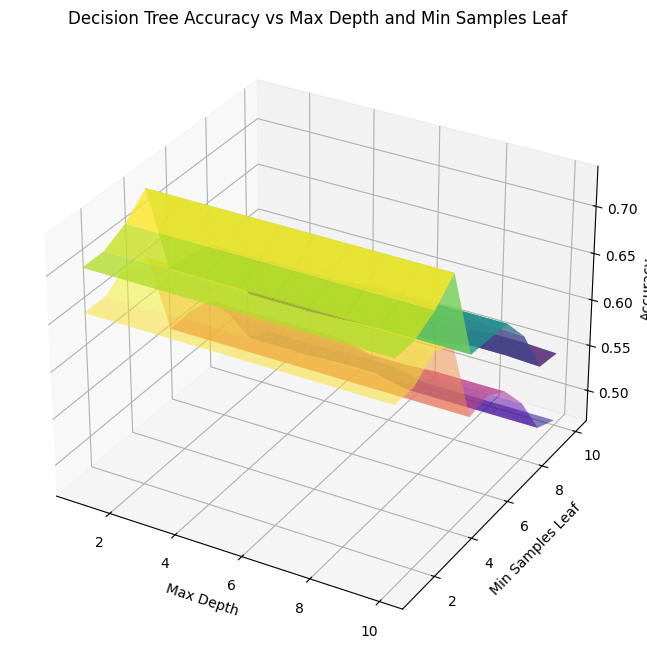

In [2]:
# Q- 1(c)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Custom train-test split function
def train_test_split(X, y, test_size=0.3, random_state=None):
    if random_state:
        np.random.seed(random_state)
    num_samples = len(X)
    test_num = int(test_size * num_samples)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    test_indices = indices[:test_num]
    train_indices = indices[test_num:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]


# Evaluate accuracy for different max_depth and min_samples_leaf
max_depths = range(1, 11)  # Values for max_depth
min_samples_leaves = range(1, 11)  # Values for min_samples_leaf
train_accuracies = np.zeros((len(max_depths), len(min_samples_leaves)))
test_accuracies = np.zeros((len(max_depths), len(min_samples_leaves)))

for i, max_depth in enumerate(max_depths):
    for j, min_samples_leaf in enumerate(min_samples_leaves):
        dt = DecisionTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        dt.train(X_train, y_train)
        y_train_pred = dt.predict(X_train)
        y_test_pred = dt.predict(X_test)
        train_accuracies[i, j] = np.mean(y_train == y_train_pred)  # Training accuracy
        test_accuracies[i, j] = np.mean(y_test == y_test_pred)  # Test accuracy

# Plot the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
X_plot, Y_plot = np.meshgrid(max_depths, min_samples_leaves)
ax.plot_surface(X_plot, Y_plot, train_accuracies, cmap='viridis', alpha=0.8, label='Train Accuracy')
ax.plot_surface(X_plot, Y_plot, test_accuracies, cmap='plasma', alpha=0.5, label='Test Accuracy')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Min Samples Leaf')
ax.set_zlabel('Accuracy')
ax.set_title('Decision Tree Accuracy vs Max Depth and Min Samples Leaf')
plt.show()

Figure illustrates the effect of max depth and minimum samples per leaf on decision tree test accuracy. Accuracy is highest for shallow to moderately deep trees with small leaf sizes, indicating a balance between underfitting and overfitting. Increasing max depth beyond this point does not improve accuracy and often degrades performance due to overfitting. Similarly, large minimum leaf sizes lead to underfitting and accuracy close to random guessing. This explains the observed test accuracy of 0.57 for suboptimal hyperparameter choices.”

In [3]:
# Q- 1(d)
import time
import numpy as np
# Measure training time
n_values = [100, 500, 1000]
d_values = [5, 10, 20]
p_values = [3, 5, 7]

for n in n_values:
    for d in d_values:
        for p in p_values:
            X = np.random.rand(n, d)
            y = np.random.randint(0, 2, n)
            dt = DecisionTree(max_depth=p)
            start_time = time.time()
            dt.train(X, y)
            train_time = time.time() - start_time
            print(f"n={n}, d={d}, p={p}: Train Time = {train_time:.4f}s")

# Measure prediction time
m_values = [100, 500, 1000]
for m in m_values:
    X_test = np.random.rand(m, d)
    start_time = time.time()
    y_pred = dt.predict(X_test)
    predict_time = time.time() - start_time
    print(f"m={m}, p={p}: Predict Time = {predict_time:.4f}s")

n=100, d=5, p=3: Train Time = 0.1077s
n=100, d=5, p=5: Train Time = 0.1626s
n=100, d=5, p=7: Train Time = 0.3361s
n=100, d=10, p=3: Train Time = 0.3562s
n=100, d=10, p=5: Train Time = 0.5990s
n=100, d=10, p=7: Train Time = 0.6133s
n=100, d=20, p=3: Train Time = 0.7011s
n=100, d=20, p=5: Train Time = 0.5791s
n=100, d=20, p=7: Train Time = 0.7573s
n=500, d=5, p=3: Train Time = 1.1718s
n=500, d=5, p=5: Train Time = 1.7888s
n=500, d=5, p=7: Train Time = 1.9865s
n=500, d=10, p=3: Train Time = 2.4140s
n=500, d=10, p=5: Train Time = 4.2127s
n=500, d=10, p=7: Train Time = 4.4930s
n=500, d=20, p=3: Train Time = 4.9559s
n=500, d=20, p=5: Train Time = 8.3168s
n=500, d=20, p=7: Train Time = 12.0209s
n=1000, d=5, p=3: Train Time = 6.7229s
n=1000, d=5, p=5: Train Time = 5.6127s
n=1000, d=5, p=7: Train Time = 7.5585s
n=1000, d=10, p=3: Train Time = 6.5544s
n=1000, d=10, p=5: Train Time = 10.2183s
n=1000, d=10, p=7: Train Time = 14.2383s
n=1000, d=20, p=3: Train Time = 17.9979s
n=1000, d=20, p=5: Trai

The training time of the decision tree increases with the number of training samples
𝑛, the feature dimension
𝑑, and the tree depth parameter
𝑝. As
𝑛 grows from 100 to 1000, training time increases substantially, reflecting the higher computational cost of evaluating splits over more samples at each node. Similarly, increasing the number of features
𝑑 leads to longer training times because more candidate splits must be considered when selecting the optimal feature and threshold. The depth parameter
𝑝 further amplifies this effect, as deeper trees create more nodes and require additional split evaluations. In contrast, prediction time remains very low and scales approximately linearly with the number of test samples
𝑚, since prediction only involves traversing the learned tree from root to leaf, resulting in negligible overhead compared to training.